## Deep Neural Network

Imports

In [197]:
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit

Load in the data

In [198]:
data_movies = pd.read_csv("data/movies.csv")
data_ratings = pd.read_csv("data/ratings.csv")

Transform the data

In [199]:
merged_dataset = pd.merge(data_movies,data_ratings, how='inner', on='movieId')

refined_dataset = merged_dataset.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})

# Encode the userid and movie title to prepare for DNN
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['userId'].to_numpy())
item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['title'].to_numpy())
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)



In [200]:
n_users = refined_dataset['user'].nunique()
n_movies = refined_dataset['movie'].nunique()
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])

Define X and Y data

In [201]:
X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values

n_factors = 100


splitter = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=50)
for train_idx, test_idx in splitter.split(X, y, groups=refined_dataset['userId']):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

X_train_array = [X_train[:, 0], X_train[:, 1]]  
X_test_array = [X_test[:, 0], X_test[:, 1]]

### Define the layers and the model

In [202]:
user = keras.layers.Input(shape = (1,))

# Embedding layer for n_factors of users
u = keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = keras.regularizers.l2(1e-6))(user)
u = keras.layers.Reshape((n_factors,))(u)

# Input layer for the movies
movie = keras.layers.Input(shape = (1,))

# Embedding layer for n_factors of movies
m = keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer= keras.regularizers.l2(1e-6))(movie)
m = keras.layers.Reshape((n_factors,))(m)

# stacking up both user and movie embeddings
x = keras.layers.Concatenate()([u,m])
x = keras.layers.Dropout(0.005)(x)

# Adding a Dense layer to the architecture
x = keras.layers.Dense(16, kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(1e-6))(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Dropout(0.005)(x)

x = keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Dropout(0.005)(x)

# Output layer 
x = keras.layers.Dense(1)(x)
x = keras.layers.Activation(activation='linear')(x)

# Define the model
model = keras.models.Model(inputs=[user,movie], outputs=x)

# Compiling the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(model.summary())

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_47      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_46        │ (None, 1, 100)    │     61,000 │ input_layer_46[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_47        │ (None, 1, 100)    │    971,900 │ input_layer_47[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_46          │ (None, 100)       │          0 │ embedding_46[0][… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_47          │ (None, 100)       │          0 │ embedding_47[0][… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_23      │ (None, 200)       │          0 │ reshape_46[0][0], │
│ (Concatenate)       │                   │            │ reshape_47[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_69          │ (None, 200)       │          0 │ concatenate_23[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 16)        │      3,216 │ dropout_69[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_69       │ (None, 16)        │          0 │ dense_69[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_70          │ (None, 16)        │          0 │ activation_69[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 16)        │        272 │ dropout_70[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_70       │ (None, 16)        │          0 │ dense_70[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_71          │ (None, 16)        │          0 │ activation_70[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 1)         │         17 │ dropout_71[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_71       │ (None, 1)         │          0 │ dense_71[0][0]    │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,036,405 (3.95 MB)

 Trainable params: 1,036,405 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

None


In [203]:

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array,
                    y = y_train,
                    batch_size=128,
                    epochs=70,
                    validation_data=(X_test_array, y_test),
                    shuffle=True,
                    callbacks=[reduce_lr])

Epoch 1/70
722/722 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 3.4194 - mae: 1.3709 - val_loss: 3.9588 - val_mae: 1.8150 - learning_rate: 0.0010
Epoch 2/70
722/722 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.7385 - mae: 0.6604 - val_loss: 2.5905 - val_mae: 1.4227 - learning_rate: 0.0010
Epoch 3/70
722/722 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.6669 - mae: 0.6218 - val_loss: 1.9513 - val_mae: 1.2041 - learning_rate: 0.0010
Epoch 4/70
722/722 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.6164 - mae: 0.5939 - val_loss: 1.5403 - val_mae: 1.0438 - learning_rate: 0.0010
Epoch 5/70
722/722 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.5633 - mae: 0.5651 - val_loss: 1.4051 - val_mae: 0.9844 - learning_rate: 0.0010
Epoch 6/70
722/722 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.5324 - mae: 0.5483 - val_loss: 1.2745 - val_mae: 0.9266 - learning_rate: 0.0010
Epoch 7/70
722/722 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.5002 - mae: 0.5288 - val_loss: 1.3438 - val_mae: 0.9545 - learning_rate: 0.001

Save the model so we don't have to train the model each time

In [206]:
model.save("data/movie_recommendation_model.keras")

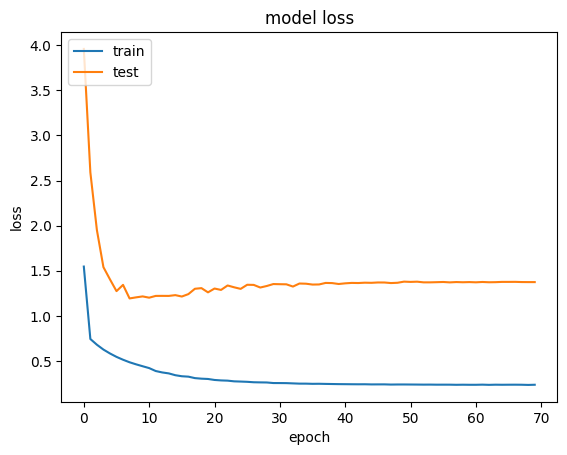

In [205]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()